# 1D Plug Flow Reactor Model with Surface Chemistry
In this model, we will illustrate the derivation of the governing differential equations and algebraic constraints, calculation of the initial conditions of the variables and their spatial derivatives and use the IDA solver to solve this system of differential algebraic equations (DAE).

Requires the [scikits.odes.dae](http://scikits-odes.readthedocs.io/en/latest/guide.html#object-oriented-interface-ode-and-dae) solver. The easiest way to install this package is from the `conda-forge` channel using `conda`.

In [11]:
import numpy as np
from scikits.odes import dae
import cantera as ct

%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

print(f"Runnning Cantera version: {ct.__version__}")

Runnning Cantera version: 3.0.0b1


## Define gas species, bulk species, surface species and the interface

Here, we use a kinetic mechanism involving the chemical vapor deposition of silicon nitride (Si<sub>3</sub>N<sub>4</sub>) from SiF<sub>4</sub> and NH<sub>3</sub>. 25 gas species, 6 surface species and 2 bulk species mechanism is applied by [Richard S. Larson et al. 1996, SAND96-8211](https://github.com/yuj056/yuj056.github.io/blob/master/_posts/Sandia.pdf).

In [12]:
# Import the reaction mechanism 
# mech = 'newer_hcof_c2_CFG.yaml'
mech = 'nist_pfas.yaml'
# mech_surf = 'methaneReformingNi.yaml'
# mech_surf = 'methane_Bjarne.yaml'
mechfile = 'methane_BLcode.yaml'

# Import the model for gas-phase
gas = ct.Solution(mech, 'gas')

# Import the model for surf-phase
surf = ct.Interface(mechfile,'surface1', [gas])
print(surf.n_reactions)

24


## Define reactor conditions : temperature, pressure, fuel, and some important parameters

In [3]:
T0 = 600  # Kelvin
p0 = 1e5
#gas.TPX = T0, p0, "N2:0.738265428, H2:1.15E-06, O:1.23E-06, OH:8.07E-05, H2O:0.130752753, CO:1.59E-06 O2:0.065447919, c-CH2CH2O:8.68E-06, CO2:0.06544046, CF4:1E-04"
#gas.TPX = T0, p0, "N2:0.714828183, H2O:0.190113878, CO2:0.095056939, CHF3:1E-06"
#gas.TPX = T0, p0, "H2O:0.190113878, CO2:0.095056939, N2:0.714828183, CF4:0.000001"
gas.TPX = T0, p0, "O2:2, CH4:0.01"
print(gas.Y)
mu = gas.viscosity
rho0 = gas.density
#print(rho0)
Yk_0 = gas.Y        # initial mass fractions
T_wall = 1290    # Wall temperature [K]
h_coeff = 0

surf.TP = T0, p0
# surf.coverages = "Pt(9): 1.0"
surf.coverages = "_Pt_: 1.0"
# surf.coverages = "Ni(s): 1.0"

# Geometry
D = 2e-3  # diameter of the tube [m]
Ac = np.pi * D**2/4  # cross-section of the tube [m^2]
perim = np.pi * D  # perimeter of the tube
N = gas.n_species  # number of gas species

# # calculate the site fractions of surface species at the entrance of the tube at steady state
surf.advance_coverages(1e1)  # Here we assume after 100s, the system reaches the steady state
Zk_0 = surf.coverages
M = surf.n_species  # number of surface species
n_var = N + M + 4

#u0 = 6.55635        # m/s initial velocity of the flow (Taken from BL input file for Re=2500, Tin = 2400K)
# u0 = 5.17628       # m/s initial velocity of the flow (Taken from BL input file for Re=2500, Tin = 2000K)
u0 = 5 #0.517628       # m/s initial velocity of the flow (Taken from BL input file for Re=250, Tin = 2000K)

[0.         0.         0.         0.99749939 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00250061 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## Define a residual function for IDA solver

For the isothermal tube with laminar flow, since the temperature of the flow and tube is constant, the energy conservation equation can be ignored. The governing equations include conservation of mass and species, momentum equation, equation of state, and the algebraic constraints that the net production rate of surface species by heterogeneous reactions are zero and that the sum of site fractions equals 1.

Here we define a residual function, an equation which should always evaluate to the zero vector, as the input of IDA solver, which listed as follows:

\begin{align}
    R[0] &= u\frac{d\rho}{dz} + \rho\frac{du}{dz} - \frac{p'}{A_c}\sum^{K_g}\dot{s}_{k,g}W_{k,g} \\
    R[1] &= \rho u A_c\frac{dY_k}{dz} + Y_k p'\sum^{K_g}\dot{s}_{k,g}W_{k,g} - \dot{\omega_k}W_kA_c - \dot{s}_{k,g}W_{k,g} p' \\
    R[2] &= 2\rho u \frac{du}{dz} + u^2\frac{d\rho}{dz} + \frac{dP}{dz} + \frac{32u\mu}{D^2}\\
    R[3] &= P\bar{W} - \rho RT\\
    R[4] &= \dot{s}_{k,s} \\
    R[5] &= \sum_{phase}{Z_{k,s}} - 1
\end{align}     

The detailed derivation of the DAE system can be found in [my report](https://github.com/yuj056/yuj056.github.io/blob/master/Week1/yuj056_github_io.pdf).

In [4]:
def residual(z, vec, vecp, result):
    """we create the residual equations for the problem
    vec = [u, rho, Yk, p, Zk]
    vecp = [dudz, drhodz, dYkdz, dpdz, dZkdz]
    """
    # temporary variables
    u = vec[0]  # velocity
    rho = vec[1]  # density
    p = vec[2]  # pressure
    T = vec[3]   # Temperature
    Y = vec[4 : 4 + N]  # vector of mass fractions of all gas species
    Z = vec[4 + N :]  # vector of site fractions of all surface species

    dudz = vecp[0]  # velocity spatial derivative
    drhodz = vecp[1]  # density spatial derivative
    dpdz = vecp[2]  # pressure spatial derivative
    dTdz = vecp[3]  # temperature spatial derivative
    dYdz = vecp[4 : 4 + N]  # mass fraction spatial derivative
    dZdz = vecp[4 + N:]  # pressure spatial derivative

    # Use unnormalized mass fractions to avoid over-constraining the system
    gas.set_unnormalized_mass_fractions(Y)
    gas.TP = T, p

    # Use unnormalized site fractions (coverages) to avoid over-constraining the system
    surf.set_unnormalized_coverages(Z)
    surf.TP = T, p

    # temporary variables (based on the given state)
    coverages = surf.coverages  # site fraction vector
    sdot_g = surf.get_net_production_rates("gas")  # heterogeneous production rate of gas species
    sdot_s = surf.get_net_production_rates("surface1")
    wdot_g = gas.net_production_rates  # homogeneous production rate of gas species
    wdot_g = np.zeros(gas.n_species)
    W_g = gas.molecular_weights  # vector of molecular weight of gas species
    
    # partial enthalpies of gas species
    hk_g = gas.partial_molar_enthalpies 

    # mass continuity equation
    result[0] = u*drhodz + rho*dudz - perim * np.sum(sdot_g * W_g) / Ac - np.sum(wdot_g*W_g*hk_g)
    
    # equation of state
    result[1] = gas.density - rho
    
    # conservation of momentum
    result[2] = 2*rho*u*dudz + np.power(u,2)*drhodz + dpdz + 32*u*mu/D**2 
    
    # energy equation
    result[3] = rho*u*Ac*gas.cp*dTdz + Ac*np.sum(wdot_g*W_g*hk_g) 
    + perim * np.sum(sdot_g*W_g*hk_g) - perim*h_coeff*(T_wall - T)
#     result[3] = dTdz

    # conservation of species
    for k in range(N):
        result[4+k] = (rho*u*Ac*dYdz[k] + Y[k] * perim * np.sum(sdot_g * W_g) 
                       - wdot_g[k]*W_g[k]*Ac - sdot_g[k] * W_g[k] * perim)
        
    # conservation of surface species
    for k in range(M):
        result[4 + N + k] = sdot_s[k]

    # replace the constraint with the condition sum(Zk) = 1 for the largest site fraction species
    index = np.argmax(coverages)
    result[4 + N + index] = np.sum(coverages) - 1

## Determine the initial values of the spatial derivatives of the unknowns which need to be used as the initial conditions for the IDA solver

We assume the derivatives of the site fractions are equal to zero, although it is trivial for the IDA solver.

In [5]:
# Initialize yPrime to 0 and call residual to get initial derivatives  
y0 = np.hstack((u0, rho0, p0, T0, Yk_0, Zk_0))
yprime0 = np.hstack(np.zeros(n_var))
result = np.hstack(np.zeros(n_var))
residual(0, y0, yprime0, result)
for n in range(n_var):
    yprime0[n] = -result[n]

## Run the IDA solver to calculate the unknowns varying in the flow direction

In [6]:
solver = dae(
    "ida",
    residual,
    first_step_size=1e-12,
    atol=1e-06,  # absolute tolerance for solution
    rtol=1e-04,  # relative tolerance for solution
    # If the given problem is of type DAE, some items of the residual vector
    # returned by the 'resfn' have to be treated as algebraic equations, and
    # algebraic variables must be defined. These algebraic variables are
    # denoted by the position (index) in the state vector y. All these
    # indexes have to be specified in the 'algebraic_vars_idx' array.
    algebraic_vars_idx=[np.arange(4 + N, 4 + N + M, 1)],
    max_steps=5000,
    old_api=False,  # Forces use of new api (namedtuple)
)
L = 0.1
times = np.arange(0,L,0.001)
solution = solver.solve(times, y0, yprime0)
print(solution)

SolverReturn(flag=0, values=SolverVariables(t=array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099]), y=array([[5.00000000e+00, 6.39821304e-01, 1.00000000e+05, ...,
        1.00995537e-12, 1.41694362e-12, 9.99735845e-01],
       [5.00006804e+00, 6.39812597e-01, 9.999863

## Plot the results

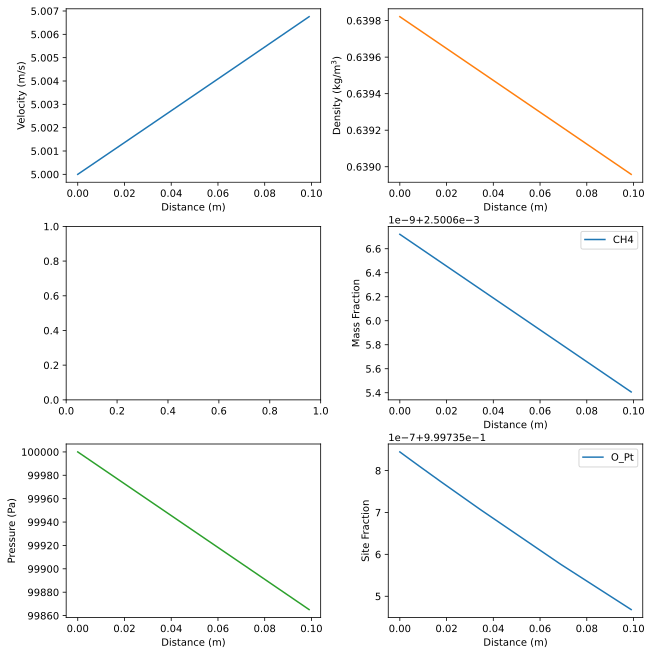

In [10]:
# plot velocity of gas along the flow direction
f, ax = plt.subplots(3, 2, figsize=(9, 9))
ax[0, 0].plot(times, solution.values.y[:, 0], color="C0")
ax[0, 0].set_xlabel("Distance (m)")
ax[0, 0].set_ylabel("Velocity (m/s)")

# plot gas density along the flow direction
ax[0, 1].plot(times, solution.values.y[:, 1], color="C1")
ax[0, 1].set_xlabel("Distance (m)")
ax[0, 1].set_ylabel(r"Density ($\mathregular{kg/m^3}$)")
ax[0, 1].ticklabel_format(
    axis="y", style="sci", scilimits=(-2, 2)
)  # scientific notation

# plot major and minor gas species separately
minor_idx = []
major_idx = []
surf_minor_idx = []
surf_major_idx = []
for i, name in enumerate(gas.species_names):
    mean = np.mean(solution.values.y[:, 4 + i])
    if mean <= 0.1:
        if (mean > 0.002):
            minor_idx.append(i)
    else:
        major_idx.append(i)
        
for i, name in enumerate(surf.species_names):
    mean = np.mean(solution.values.y[:, 4 + N + i])
    if mean <= 0.5:
        surf_minor_idx.append(i)
    else:
        surf_major_idx.append(i)

# # plot minor species
# for i in minor_idx:
#     style = "-" if i < 10 else "--"
#     ax[1, 0].plot(times, solution.values.y[:, 4 + i], label=gas.species_names[i], linestyle=style)
# ax[1, 0].legend(fontsize=7, loc="upper right")
# ax[1, 0].set_xlabel("Distance (m)")
# ax[1, 0].set_ylabel("Mass Fraction")
# ax[1, 0].ticklabel_format(
#     axis="y", style="sci", scilimits=(-2, 2)
# )  # scientific notation

# for i in minor_idx:
#     #ax[1, 0].plot(times, solution.values.y[:, 4 + i], label=gas.species_names[i], linestyle=style)
#     ax[1, 0].plot(times, solution.values.y[:,3], color="C2")
# ax[1, 0].legend(fontsize=7, loc="upper right")
# ax[1, 0].set_xlabel("Distance (m)")
# ax[1, 0].set_ylabel("Temperature (K)")
# ax[1, 0].ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))  # scientific notation

# plot major species
for j in minor_idx:
    ax[1, 1].plot(times, solution.values.y[:, 4 + j], label=gas.species_names[j])
ax[1, 1].legend(loc="best")
ax[1, 1].set_xlabel("Distance (m)")
ax[1, 1].set_ylabel("Mass Fraction")

# plot the pressure of the gas along the flow direction
ax[2, 0].plot(times, solution.values.y[:, 2], color="C2")
ax[2, 0].set_xlabel("Distance (m)")
ax[2, 0].set_ylabel("Pressure (Pa)")

# plot the site fraction of the surface species along the flow direction
# for i, name in enumerate(surf.species_names):
#     ax[2, 1].plot(times, solution.values.y[:, 4 + N + i], label=name)
for j in surf_major_idx:
    ax[2, 1].plot(times, solution.values.y[:, 4 + N + j], label=surf.species_names[j])
ax[2, 1].legend()
ax[2, 1].set_xlabel("Distance (m)")
ax[2, 1].set_ylabel("Site Fraction")
f.tight_layout(pad=0.5)